<a href="https://colab.research.google.com/github/Nunuy15/Thesis/blob/main/MobileNetV3_Dasar_NoDO_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Tahap 1: Inisialisasi Generator Gambar**
Pada tahap ini, kita membuat ImageDataGenerator dan mengatur fungsi preprocessing agar sesuai dengan MobileNetV3.

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menggunakan ImageDataGenerator dengan fungsi preprocessing MobileNetV3
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

# **Tahap 2: Memuat Gambar dari Direktori**
Pada tahap ini, kita membuat generator gambar (train_generator) untuk menghasilkan gambar dari direktori training. Gambar-gambar ini akan diproses sesuai target size yang ditentukan.

In [6]:
# Directories
train_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/train'
val_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/valid'
test_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/test'

# Ukuran gambar dan batch size
img_height, img_width = 224, 224
batch_size = 32

# Membuat generator untuk memuat gambar dari direktori
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3570 images belonging to 6 classes.
Found 1020 images belonging to 6 classes.
Found 510 images belonging to 6 classes.


# **Tahap 3: Fungsi untuk Menampilkan Gambar dari Setiap Kelas**
Pada tahap ini, kita membuat fungsi untuk menampilkan satu gambar acak dari setiap kelas dalam batch pertama yang dihasilkan oleh generator.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images_from_each_class(generator, class_names, img_height=224, img_width=224):
    """
    Fungsi untuk menampilkan gambar acak dari setiap kelas dalam generator gambar.

    Parameters:
    - generator: ImageDataGenerator yang telah dikonfigurasi
    - class_names: Daftar nama kelas
    - img_height, img_width: Dimensi gambar
    """
    # Menyimpan gambar acak dari setiap kelas
    random_images = {}

    # Mengambil batch pertama dari generator
    for images, labels in generator:
        for i in range(len(images)):
            label = np.argmax(labels[i])  # Mengambil indeks kelas
            class_name = class_names[label]

            # Simpan satu gambar dari setiap kelas
            if class_name not in random_images:
                random_images[class_name] = images[i]

        # Jika sudah memiliki satu gambar dari setiap kelas, hentikan loop
        if len(random_images) == len(class_names):
            break

    # Visualisasi gambar acak dari setiap kelas
    plt.figure(figsize=(15, 8))
    for i, (class_name, image) in enumerate(random_images.items()):
        ax = plt.subplot(1, len(class_names), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis("off")
    plt.show()

# **Tahap 4: Menjalankan Fungsi dan Menampilkan Hasil**
Pada tahap ini, kita menjalankan fungsi yang telah dibuat untuk menampilkan gambar dari setiap kelas. Kita juga mengambil nama kelas dari train_generator untuk memastikan bahwa setiap kelas tercakup.

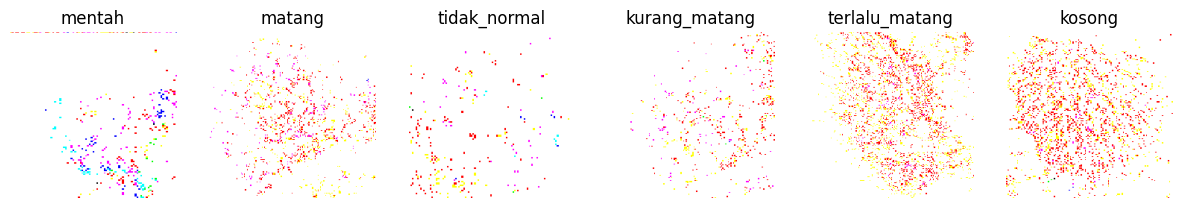

In [8]:
# Mendapatkan nama kelas dari train_generator
class_names = list(train_generator.class_indices.keys())

# Tampilkan gambar acak dari setiap kelas
show_random_images_from_each_class(train_generator, class_names)

# **Tahap 5: Pembuatan Model**
Pada tahap ini, kita membangun model menggunakan MobileNetV3 sebagai base model, menambahkan beberapa layer tambahan untuk menyesuaikan output dengan jumlah kelas yang diinginkan.

In [11]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV3 Small model sebagai base model tanpa lapisan klasifikasi teratas
base_model = MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights='imagenet',
    include_preprocessing=True
)

# Membekukan base model untuk transfer learning
base_model.trainable = False

# Menambahkan lapisan custom di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(len(class_names), activation='softmax')(x)  # Sesuaikan output dengan jumlah kelas

# Definisikan model keseluruhan
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Tahap 6: Melatih Model**
Melatih model menggunakan generator data yang telah dikonfigurasi sebelumnya, yaitu `train_generator` dan `val_generator`.

In [12]:
# Jumlah epoch untuk training
epochs = 50  # Anda bisa menyesuaikan jumlah epoch sesuai kebutuhan

# Melatih model dan menyimpan hasil pelatihan dalam variabel history
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 631s 5s/step - accuracy: 0.2542 - loss: 1.7479 - val_accuracy: 0.5873 - val_loss: 1.2410
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 383ms/step - accuracy: 0.6184 - loss: 1.1404 - val_accuracy: 0.6775 - val_loss: 0.9641
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 392ms/step - accuracy: 0.6833 - loss: 0.9115 - val_accuracy: 0.7049 - val_loss: 0.8466
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.7342 - loss: 0.7927 - val_accuracy: 0.7147 - val_loss: 0.7682
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.7480 - loss: 0.7241 - val_accuracy: 0.7284 - val_loss: 0.7248
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 364ms/step - accuracy: 0.7777 - loss: 0.6590 - val_accuracy: 0.7441 - val_loss: 0.6905
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 354ms/step - accuracy: 0.7968 - loss: 0.6056 - val_accuracy: 0.7539 - val_loss: 0.6573
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 378ms/step - accuracy: 0.8090 - loss: 0.5

# **Tahap 7: Evaluasi Model**
Melakukan evaluasi pada data test dan menghasilkan laporan klasifikasi serta confusion matrix untuk mengetahui performa model pada data yang belum pernah dilihat.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Prediksi pada data test
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Laporan klasifikasi
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step
                precision    recall  f1-score     support
kosong           0.965517  0.988235  0.976744   85.000000
kurang_matang    0.767442  0.776471  0.771930   85.000000
matang           0.841463  0.811765  0.826347   85.000000
mentah           0.901235  0.858824  0.879518   85.000000
terlalu_matang   0.875000  0.905882  0.890173   85.000000
tidak_normal     0.837209  0.847059  0.842105   85.000000
accuracy         0.864706  0.864706  0.864706    0.864706
macro avg        0.864644  0.864706  0.864470  510.000000
weighted avg     0.864644  0.864706  0.864470  510.000000


# **Tahap 8: Visualisasi Hasil Training dan Evaluasi**

# 8.1. Visualisasi Akurasi Training dan Validation
Menampilkan grafik akurasi training dan validation dari hasil pelatihan untuk memantau kinerja model.

In [15]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


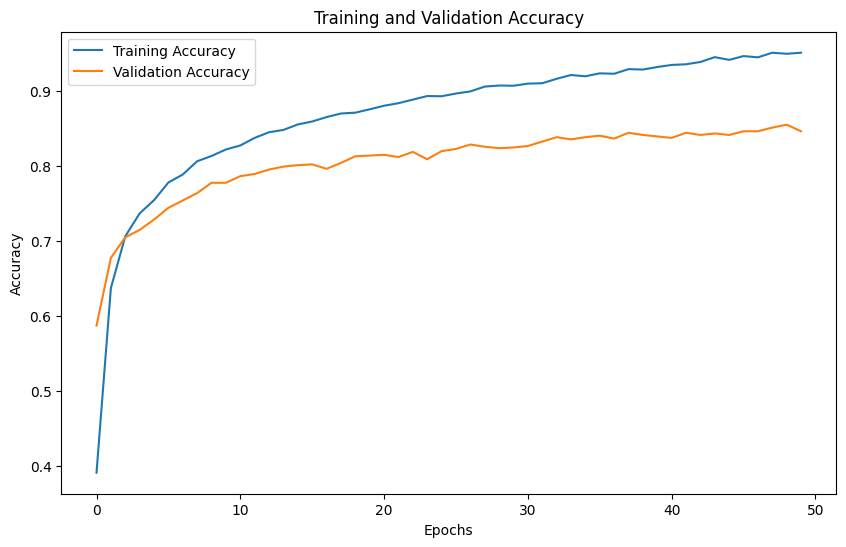

In [16]:
import matplotlib.pyplot as plt

# Plot Akurasi Training dan Validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

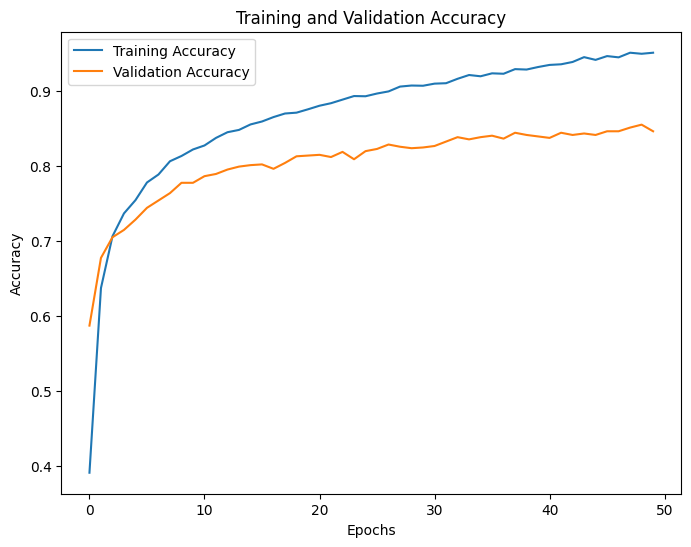

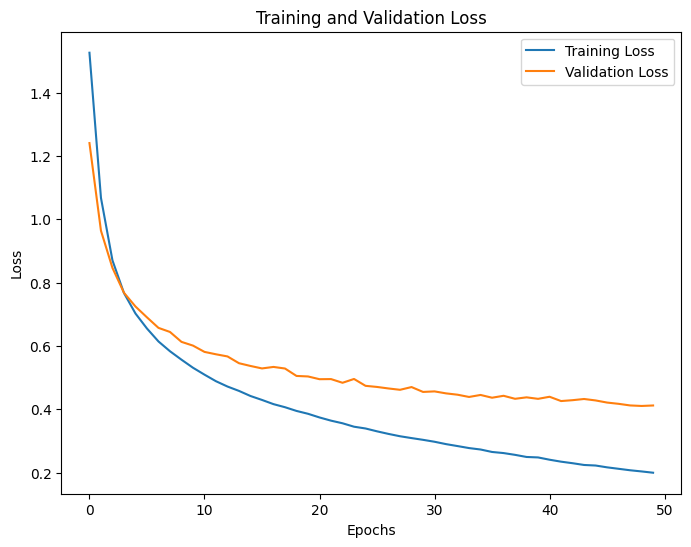

In [17]:
import matplotlib.pyplot as plt

# Plot Akurasi Training dan Validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss Training dan Validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# 8.2. Visualisasi Precision, Recall, dan F1 Score per Kelas
Menampilkan precision, recall, dan f1-score untuk setiap kelas.

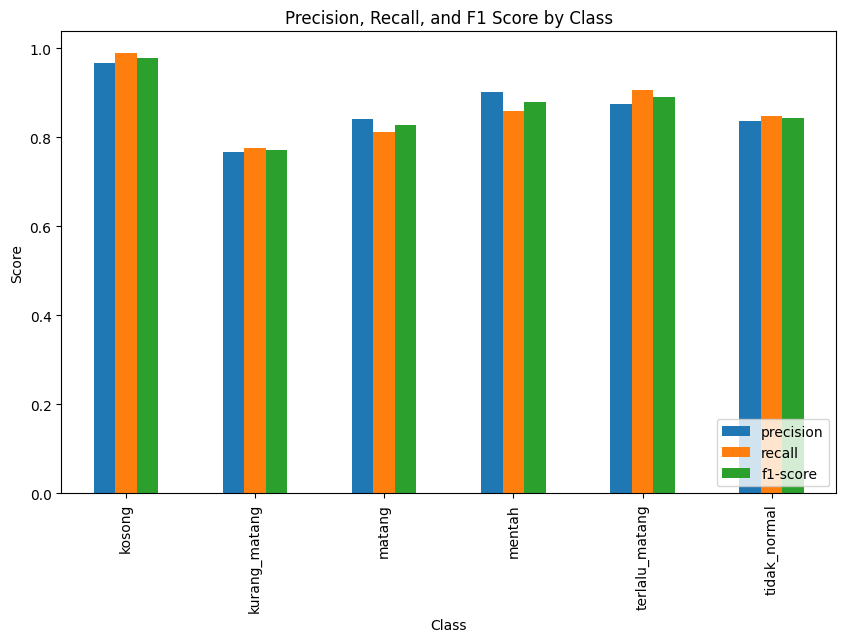

In [18]:
# Visualisasi precision, recall, dan f1-score per kelas
df_metrics = df_report.loc[class_names, ["precision", "recall", "f1-score"]]
df_metrics.plot(kind="bar", figsize=(10, 6))
plt.title("Precision, Recall, and F1 Score by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.show()

# 8.3. Visualisasi Confusion Matrix
Menampilkan confusion matrix untuk memeriksa kesalahan klasifikasi model pada data test.

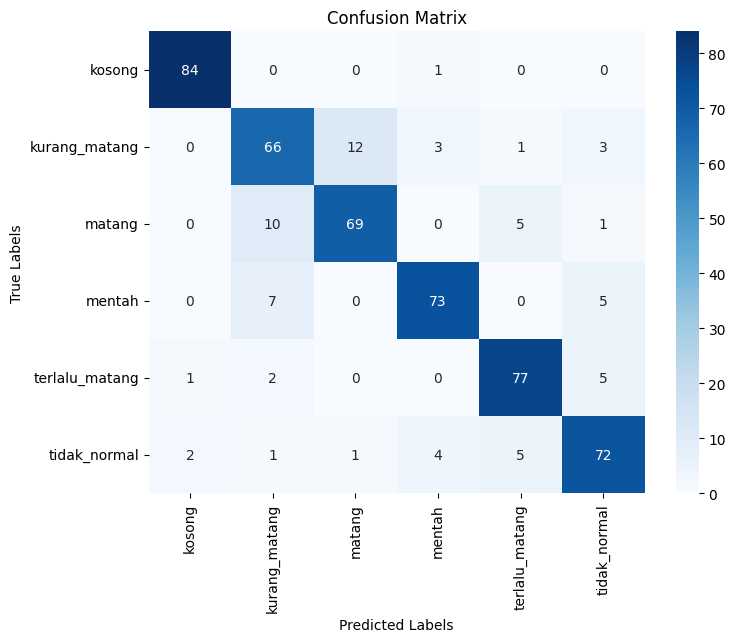

In [19]:
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# **Tahap 9: Menyimpan Model**
Simpan model yang telah dilatih untuk digunakan di masa mendatang.

In [20]:
# Menyimpan model
model.save('/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/saved_model_mobileNetV3Large_nodropuot.keras')